# 1. Imports

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as transforms

# Library for augmentations
import albumentations as A

# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

In [2]:
def train_transform(rotate: bool=True):
    funcs = []
    
    # Random change of brightness and contrast
    funcs.append(A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1))
    
    if rotate:
        # Random rotation
        funcs.append(A.augmentations.geometric.rotate.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1))
    
        ret = A.Compose([A.Sequential(funcs, p=1)], keypoint_params=A.KeypointParams(format='xy'),
              bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']))
    
    else:
        ret = A.Compose([A.Sequential(funcs, p=1)], )
    
    return ret

# 3. Dataset class

In [3]:
class ClassDataset(Dataset):
    def __init__(self, images: list, annotations: list, transform=None, demo=False, filenames=None):                
        #self.root = root
        self.transform = transform
        # Use demo=True if you need transformed and original images (visualization purposes)
        self.demo = demo
        self.images = images
        self.annotations = annotations
        # If filenames are set, it will be printed when image is accessed (logging purposes)
        self.filenames = filenames
    
    def __getitem__(self, idx):
        img_original = self.images[idx]
        bboxes_original = self.annotations[idx]['bboxes']
        keypoints_original = self.annotations[idx]['keypoints']
        bboxes_labels_original = ['Car wheel' for _ in bboxes_original]           

        if self.transform:   
            # Converting keypoints from [x, y, visibility]-format to [x, y]-format + Flattening nested list of keypoints 
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations (while loop to retry different rotation if a rotation crops away a keypoint)
            keypoints = []
            while len(keypoints) != len(keypoints_original_flattened):
                transform = self.transform(rotate=True)
                # Try-except block because some bboxes get mangled in the transformation process (negative width or height)
                try:
                    transformed = transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
                except ValueError:
                    transform = self.transform(rotate=False)
                    transformed = transform(image=img_original)
                    transformed['bboxes'] = bboxes_original
                    transformed['keypoints'] = keypoints_original_flattened

                img = transformed['image']
                bboxes = transformed['bboxes']
                keypoints = transformed['keypoints']
            
            if self.filenames:
                print(self.filenames[idx])
            
            # Unflattening [[x, y], [x, y], ...] keypoints into [[[x, y], [x, y], [x, y], [x, y], [x, y]], [...], [...]]
            keypoints_transformed_unflattened = np.reshape(np.array(keypoints), (-1, 5, 2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x, y, visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
                
        # No transformation
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target['boxes'] = bboxes
        # All objects are car wheels
        target['labels'] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target['iscrowd'] = torch.zeros(len(bboxes), dtype=torch.int64)
        target['keypoints'] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original['boxes'] = bboxes_original
        # All objects are car wheels
        target_original['labels'] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64)
        target_original['image_id'] = torch.tensor([idx])
        target_original['area'] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original['iscrowd'] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original['keypoints'] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.images)

# 4. Visualizing a random item from dataset

In [4]:
keypoints_classes_ids2names = {0: 'Top', 1: 'Bottom', 2: 'Right', 3: 'Sidewall', 4: 'Width'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image_original is not None:
        image_original = cv2.cvtColor(image_original, cv2.COLOR_GRAY2RGB)

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

In [5]:
def load_dataset():

    path_to_images = 'dataset/images'
    path_to_annotations = 'dataset/annotations'

    image_filenames = sorted(os.listdir(path_to_images))
    images = [cv2.imread(os.path.join(path_to_images, file), cv2.IMREAD_GRAYSCALE) for file in image_filenames]

    annotation_filenames = sorted(os.listdir(path_to_annotations))
    annotations = []
    for file in annotation_filenames:
        with open(os.path.join(path_to_annotations, file), 'r') as annotation:
            annotations.append(json.load(annotation))
    
    return images, annotations, image_filenames

2_013.jpg


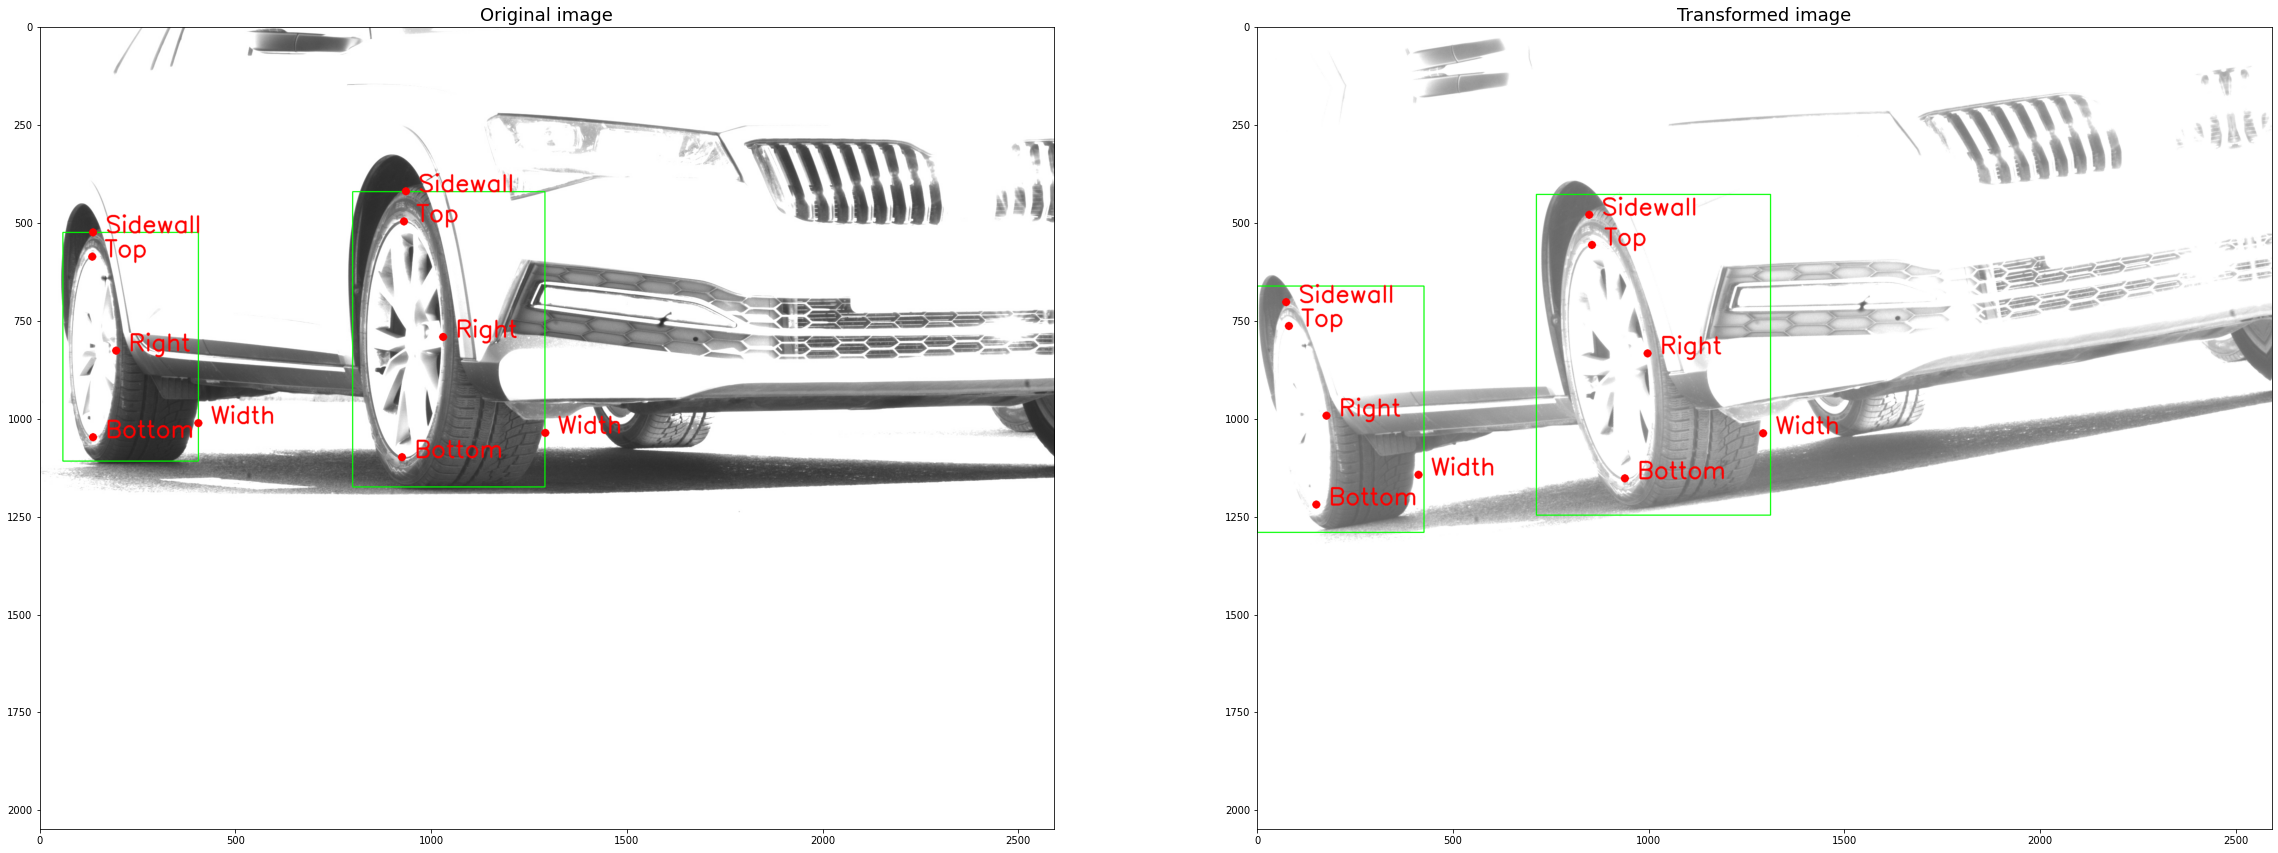

In [8]:
images, annotations, filenames = load_dataset()

dataset = ClassDataset(images, annotations, transform=train_transform, demo=True, filenames=filenames)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [9]:
def get_model(num_keypoints, weights_path=None):
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   # One class for car wheel, one class for background
                                                                   num_classes=2,
                                                                   rpn_anchor_generator=anchor_generator)
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [10]:
def test_train_split_indexes(dataset_length: int, train_size: float=0.8, seed: int=None):
    """
    Split indexes of array into train/test
    
    [0, 1, 2, 3, 4, 5] => [0, 2, 3, 5], [1, 4]
    """
    
    if not 0 < train_size <= 1:
        raise ValueError('Invalid train size (must be between 0 and 1, 80/20 would be 0.8 train_size,)')
    
    if seed is not None:
        np.random.seed(seed)
        
    indexes = np.indices([dataset_length])[0]
    np.random.shuffle(indexes)
    np.random.seed()
    
    train_size = int(round(dataset_length * train_size, 0))
    train_indexes = indexes[:train_size]
    test_indexes = indexes[train_size:]
    train_indexes.sort()
    test_indexes.sort()
    
    return train_indexes.tolist(), test_indexes.tolist()

def test_train_split(dataset: list, train_size: float=0.8, seed: int=None):
    """Split dataset into training and testing datasets"""
    
    train_indexes, test_indexes = test_train_split_indexes(len(dataset), train_size, seed)
    
    train = []
    test = []
    
    for train_index in train_indexes:
        train.append(dataset[train_index])
    for test_index in test_indexes:
        test.append(dataset[test_index])
        
    return train, test

In [12]:
# Load dataset
images, annotations, filenames = load_dataset()

# Split into train and test datasets with 66/34 split
seed = 666
train_size = 0.66
train_images, test_images = test_train_split(images, train_size, seed)
train_annotations, test_annotations = test_train_split(annotations, train_size, seed)
train_filenames, test_filenames = test_train_split(filenames, train_size, seed)

# Create objects used by PyTorch, add transformation function to train data (artificial diversity)
dataset_train = ClassDataset(train_images, train_annotations, transform=train_transform, demo=False)
dataset_test = ClassDataset(test_images, test_annotations, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Prepare model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_keypoints=5)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 25

# Training
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model after training
torch.save(model.state_dict(), 'saved_model.pth')

Epoch: [0]  [  0/100]  eta: 0:00:23  lr: 0.000011  loss: 9.6616 (9.6616)  loss_classifier: 0.7665 (0.7665)  loss_box_reg: 0.1003 (0.1003)  loss_keypoint: 8.0849 (8.0849)  loss_objectness: 0.6929 (0.6929)  loss_rpn_box_reg: 0.0170 (0.0170)  time: 0.2304  data: 0.0199  max mem: 1814
Epoch: [0]  [ 99/100]  eta: 0:00:00  lr: 0.001000  loss: 6.0418 (7.5952)  loss_classifier: 0.1181 (0.2555)  loss_box_reg: 0.1773 (0.0943)  loss_keypoint: 5.7607 (6.7957)  loss_objectness: 0.0848 (0.4388)  loss_rpn_box_reg: 0.0095 (0.0108)  time: 0.2366  data: 0.0232  max mem: 2369
Epoch: [0] Total time: 0:00:21 (0.2170 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:10  model_time: 0.1740 (0.1740)  evaluator_time: 0.0109 (0.0109)  time: 0.2132  data: 0.0242  max mem: 2369
Test:  [50/51]  eta: 0:00:00  model_time: 0.1633 (0.1560)  evaluator_time: 0.0104 (0.0098)  time: 0.1851  data: 0.0192  max mem: 2369
Test: Total time: 0:00:09 (0.1897 s / it)
Averaged stats: model_time: 0.1633 (0.1560)  e

Epoch: [3]  [  0/100]  eta: 0:00:26  lr: 0.001000  loss: 4.2379 (4.2379)  loss_classifier: 0.0788 (0.0788)  loss_box_reg: 0.1341 (0.1341)  loss_keypoint: 4.0117 (4.0117)  loss_objectness: 0.0117 (0.0117)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 0.2663  data: 0.0269  max mem: 2441
Epoch: [3]  [ 99/100]  eta: 0:00:00  lr: 0.001000  loss: 3.8264 (4.2609)  loss_classifier: 0.0573 (0.0800)  loss_box_reg: 0.1109 (0.1404)  loss_keypoint: 3.6489 (4.0143)  loss_objectness: 0.0134 (0.0180)  loss_rpn_box_reg: 0.0048 (0.0082)  time: 0.2667  data: 0.0226  max mem: 2441
Epoch: [3] Total time: 0:00:26 (0.2698 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0847 (0.0847)  evaluator_time: 0.0014 (0.0014)  time: 0.1090  data: 0.0191  max mem: 2441
Test:  [50/51]  eta: 0:00:00  model_time: 0.0887 (0.0891)  evaluator_time: 0.0027 (0.0029)  time: 0.1119  data: 0.0161  max mem: 2441
Test: Total time: 0:00:05 (0.1147 s / it)
Averaged stats: model_time: 0.0887 (0.0891)  e

Epoch: [6]  [  0/100]  eta: 0:00:25  lr: 0.000300  loss: 2.9393 (2.9393)  loss_classifier: 0.0673 (0.0673)  loss_box_reg: 0.0716 (0.0716)  loss_keypoint: 2.7929 (2.7929)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.2570  data: 0.0294  max mem: 2530
Epoch: [6]  [ 99/100]  eta: 0:00:00  lr: 0.000300  loss: 3.1433 (3.1201)  loss_classifier: 0.0451 (0.0660)  loss_box_reg: 0.0931 (0.1059)  loss_keypoint: 2.9843 (2.9321)  loss_objectness: 0.0062 (0.0108)  loss_rpn_box_reg: 0.0049 (0.0053)  time: 0.2828  data: 0.0215  max mem: 2530
Epoch: [6] Total time: 0:00:28 (0.2803 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0840 (0.0840)  evaluator_time: 0.0014 (0.0014)  time: 0.1044  data: 0.0153  max mem: 2530
Test:  [50/51]  eta: 0:00:00  model_time: 0.0866 (0.0863)  evaluator_time: 0.0023 (0.0025)  time: 0.1098  data: 0.0162  max mem: 2530
Test: Total time: 0:00:05 (0.1089 s / it)
Averaged stats: model_time: 0.0866 (0.0863)  e

Epoch: [9]  [  0/100]  eta: 0:00:37  lr: 0.000300  loss: 3.6987 (3.6987)  loss_classifier: 0.1004 (0.1004)  loss_box_reg: 0.1935 (0.1935)  loss_keypoint: 3.3921 (3.3921)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 0.3797  data: 0.0246  max mem: 2530
Epoch: [9]  [ 99/100]  eta: 0:00:00  lr: 0.000300  loss: 2.7424 (2.8056)  loss_classifier: 0.0537 (0.0611)  loss_box_reg: 0.0822 (0.0981)  loss_keypoint: 2.5168 (2.6334)  loss_objectness: 0.0067 (0.0081)  loss_rpn_box_reg: 0.0049 (0.0048)  time: 0.2780  data: 0.0209  max mem: 2530
Epoch: [9] Total time: 0:00:28 (0.2827 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0842 (0.0842)  evaluator_time: 0.0015 (0.0015)  time: 0.1059  data: 0.0153  max mem: 2530
Test:  [50/51]  eta: 0:00:00  model_time: 0.0845 (0.0857)  evaluator_time: 0.0022 (0.0024)  time: 0.1074  data: 0.0157  max mem: 2530
Test: Total time: 0:00:05 (0.1077 s / it)
Averaged stats: model_time: 0.0845 (0.0857)  e

Epoch: [12]  [  0/100]  eta: 0:00:28  lr: 0.000090  loss: 2.4007 (2.4007)  loss_classifier: 0.0381 (0.0381)  loss_box_reg: 0.0797 (0.0797)  loss_keypoint: 2.2751 (2.2751)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0041 (0.0041)  time: 0.2803  data: 0.0183  max mem: 2530
Epoch: [12]  [ 99/100]  eta: 0:00:00  lr: 0.000090  loss: 2.3996 (2.4346)  loss_classifier: 0.0468 (0.0575)  loss_box_reg: 0.0613 (0.0908)  loss_keypoint: 2.2446 (2.2759)  loss_objectness: 0.0034 (0.0064)  loss_rpn_box_reg: 0.0026 (0.0040)  time: 0.2758  data: 0.0218  max mem: 2530
Epoch: [12] Total time: 0:00:28 (0.2879 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0825 (0.0825)  evaluator_time: 0.0014 (0.0014)  time: 0.1038  data: 0.0149  max mem: 2530
Test:  [50/51]  eta: 0:00:00  model_time: 0.0846 (0.0847)  evaluator_time: 0.0022 (0.0023)  time: 0.1082  data: 0.0169  max mem: 2530
Test: Total time: 0:00:05 (0.1098 s / it)
Averaged stats: model_time: 0.0846 (0.0847)

Epoch: [15]  [  0/100]  eta: 0:00:22  lr: 0.000027  loss: 1.9029 (1.9029)  loss_classifier: 0.0380 (0.0380)  loss_box_reg: 0.0726 (0.0726)  loss_keypoint: 1.7819 (1.7819)  loss_objectness: 0.0081 (0.0081)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 0.2224  data: 0.0250  max mem: 2781
Epoch: [15]  [ 99/100]  eta: 0:00:00  lr: 0.000027  loss: 2.2508 (2.2798)  loss_classifier: 0.0548 (0.0543)  loss_box_reg: 0.0888 (0.0878)  loss_keypoint: 2.0751 (2.1280)  loss_objectness: 0.0045 (0.0055)  loss_rpn_box_reg: 0.0041 (0.0042)  time: 0.2994  data: 0.0231  max mem: 2781
Epoch: [15] Total time: 0:00:28 (0.2881 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0817 (0.0817)  evaluator_time: 0.0013 (0.0013)  time: 0.1028  data: 0.0156  max mem: 2781
Test:  [50/51]  eta: 0:00:00  model_time: 0.0832 (0.0833)  evaluator_time: 0.0019 (0.0020)  time: 0.1072  data: 0.0174  max mem: 2781
Test: Total time: 0:00:05 (0.1062 s / it)
Averaged stats: model_time: 0.0832 (0.0833)

Epoch: [18]  [  0/100]  eta: 0:00:30  lr: 0.000027  loss: 2.2054 (2.2054)  loss_classifier: 0.0400 (0.0400)  loss_box_reg: 0.0767 (0.0767)  loss_keypoint: 2.0783 (2.0783)  loss_objectness: 0.0086 (0.0086)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 0.3069  data: 0.0238  max mem: 2781
Epoch: [18]  [ 99/100]  eta: 0:00:00  lr: 0.000027  loss: 1.9278 (2.2209)  loss_classifier: 0.0471 (0.0552)  loss_box_reg: 0.0709 (0.0865)  loss_keypoint: 1.8001 (2.0678)  loss_objectness: 0.0033 (0.0068)  loss_rpn_box_reg: 0.0021 (0.0046)  time: 0.2756  data: 0.0221  max mem: 2781
Epoch: [18] Total time: 0:00:28 (0.2890 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0828 (0.0828)  evaluator_time: 0.0013 (0.0013)  time: 0.1045  data: 0.0169  max mem: 2781
Test:  [50/51]  eta: 0:00:00  model_time: 0.0827 (0.0836)  evaluator_time: 0.0020 (0.0021)  time: 0.1071  data: 0.0167  max mem: 2781
Test: Total time: 0:00:05 (0.1064 s / it)
Averaged stats: model_time: 0.0827 (0.0836)

Epoch: [21]  [  0/100]  eta: 0:00:29  lr: 0.000008  loss: 2.5535 (2.5535)  loss_classifier: 0.0707 (0.0707)  loss_box_reg: 0.0890 (0.0890)  loss_keypoint: 2.3871 (2.3871)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 0.2932  data: 0.0284  max mem: 2799
Epoch: [21]  [ 99/100]  eta: 0:00:00  lr: 0.000008  loss: 1.7326 (2.2088)  loss_classifier: 0.0333 (0.0564)  loss_box_reg: 0.0522 (0.0866)  loss_keypoint: 1.6726 (2.0557)  loss_objectness: 0.0021 (0.0059)  loss_rpn_box_reg: 0.0028 (0.0042)  time: 0.2994  data: 0.0193  max mem: 2799
Epoch: [21] Total time: 0:00:28 (0.2872 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0819 (0.0819)  evaluator_time: 0.0013 (0.0013)  time: 0.1060  data: 0.0190  max mem: 2799
Test:  [50/51]  eta: 0:00:00  model_time: 0.0817 (0.0824)  evaluator_time: 0.0017 (0.0019)  time: 0.1029  data: 0.0144  max mem: 2799
Test: Total time: 0:00:05 (0.1020 s / it)
Averaged stats: model_time: 0.0817 (0.0824)

Epoch: [24]  [  0/100]  eta: 0:00:27  lr: 0.000008  loss: 2.0081 (2.0081)  loss_classifier: 0.0648 (0.0648)  loss_box_reg: 0.0684 (0.0684)  loss_keypoint: 1.8703 (1.8703)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 0.2719  data: 0.0261  max mem: 2817
Epoch: [24]  [ 99/100]  eta: 0:00:00  lr: 0.000008  loss: 1.7948 (2.2016)  loss_classifier: 0.0404 (0.0558)  loss_box_reg: 0.0645 (0.0862)  loss_keypoint: 1.7233 (2.0491)  loss_objectness: 0.0028 (0.0061)  loss_rpn_box_reg: 0.0020 (0.0044)  time: 0.2681  data: 0.0227  max mem: 2817
Epoch: [24] Total time: 0:00:28 (0.2896 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0820 (0.0820)  evaluator_time: 0.0014 (0.0014)  time: 0.1061  data: 0.0181  max mem: 2817
Test:  [50/51]  eta: 0:00:00  model_time: 0.0829 (0.0831)  evaluator_time: 0.0020 (0.0020)  time: 0.1050  data: 0.0158  max mem: 2817
Test: Total time: 0:00:05 (0.1051 s / it)
Averaged stats: model_time: 0.0829 (0.0831)

# 6. Testing model accuracy (manual evaluation)

In [13]:
# Load model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_keypoints=5)
model.to(device)

model.load_state_dict(torch.load('saved_model.pth', map_location=device))
model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [20]:
def predict(original_image: np.ndarray):
    # Convert to tensor
    image = F.to_tensor(original_image)
    # Add batch dimension
    image = image.unsqueeze(0).to(device)

    # Turn off context manager for gradient calculation (memory saving)
    with torch.no_grad():
        output = model(image)

    scores = output[0]['scores'].detach().cpu().numpy()

    if len(scores) == 0:
        print('No hits')
    else:
        # Detections are sorted by score, highest is first
        best = 0
        print(f'Confidence: {scores[best]:.2f}')
        # If you desire to find multiple car wheels, not just the best one, then you have to use NMS to eliminate
        # overlapping objects (because second best object might be referring to the same car wheel, just with less
        # confidence), see https://pytorch.org/vision/main/generated/torchvision.ops.nms.html

        # Get keypoints and bounding box from output
        keypoints = []
        for point in output[0]['keypoints'][best].detach().cpu().numpy():
            keypoints.append([int(point[0]), int(point[1])])

        bbox = [int(i) for i in output[0]['boxes'][best].detach().cpu().numpy()]

        visualize(original_image, [bbox], [keypoints])

Confidence: 1.00


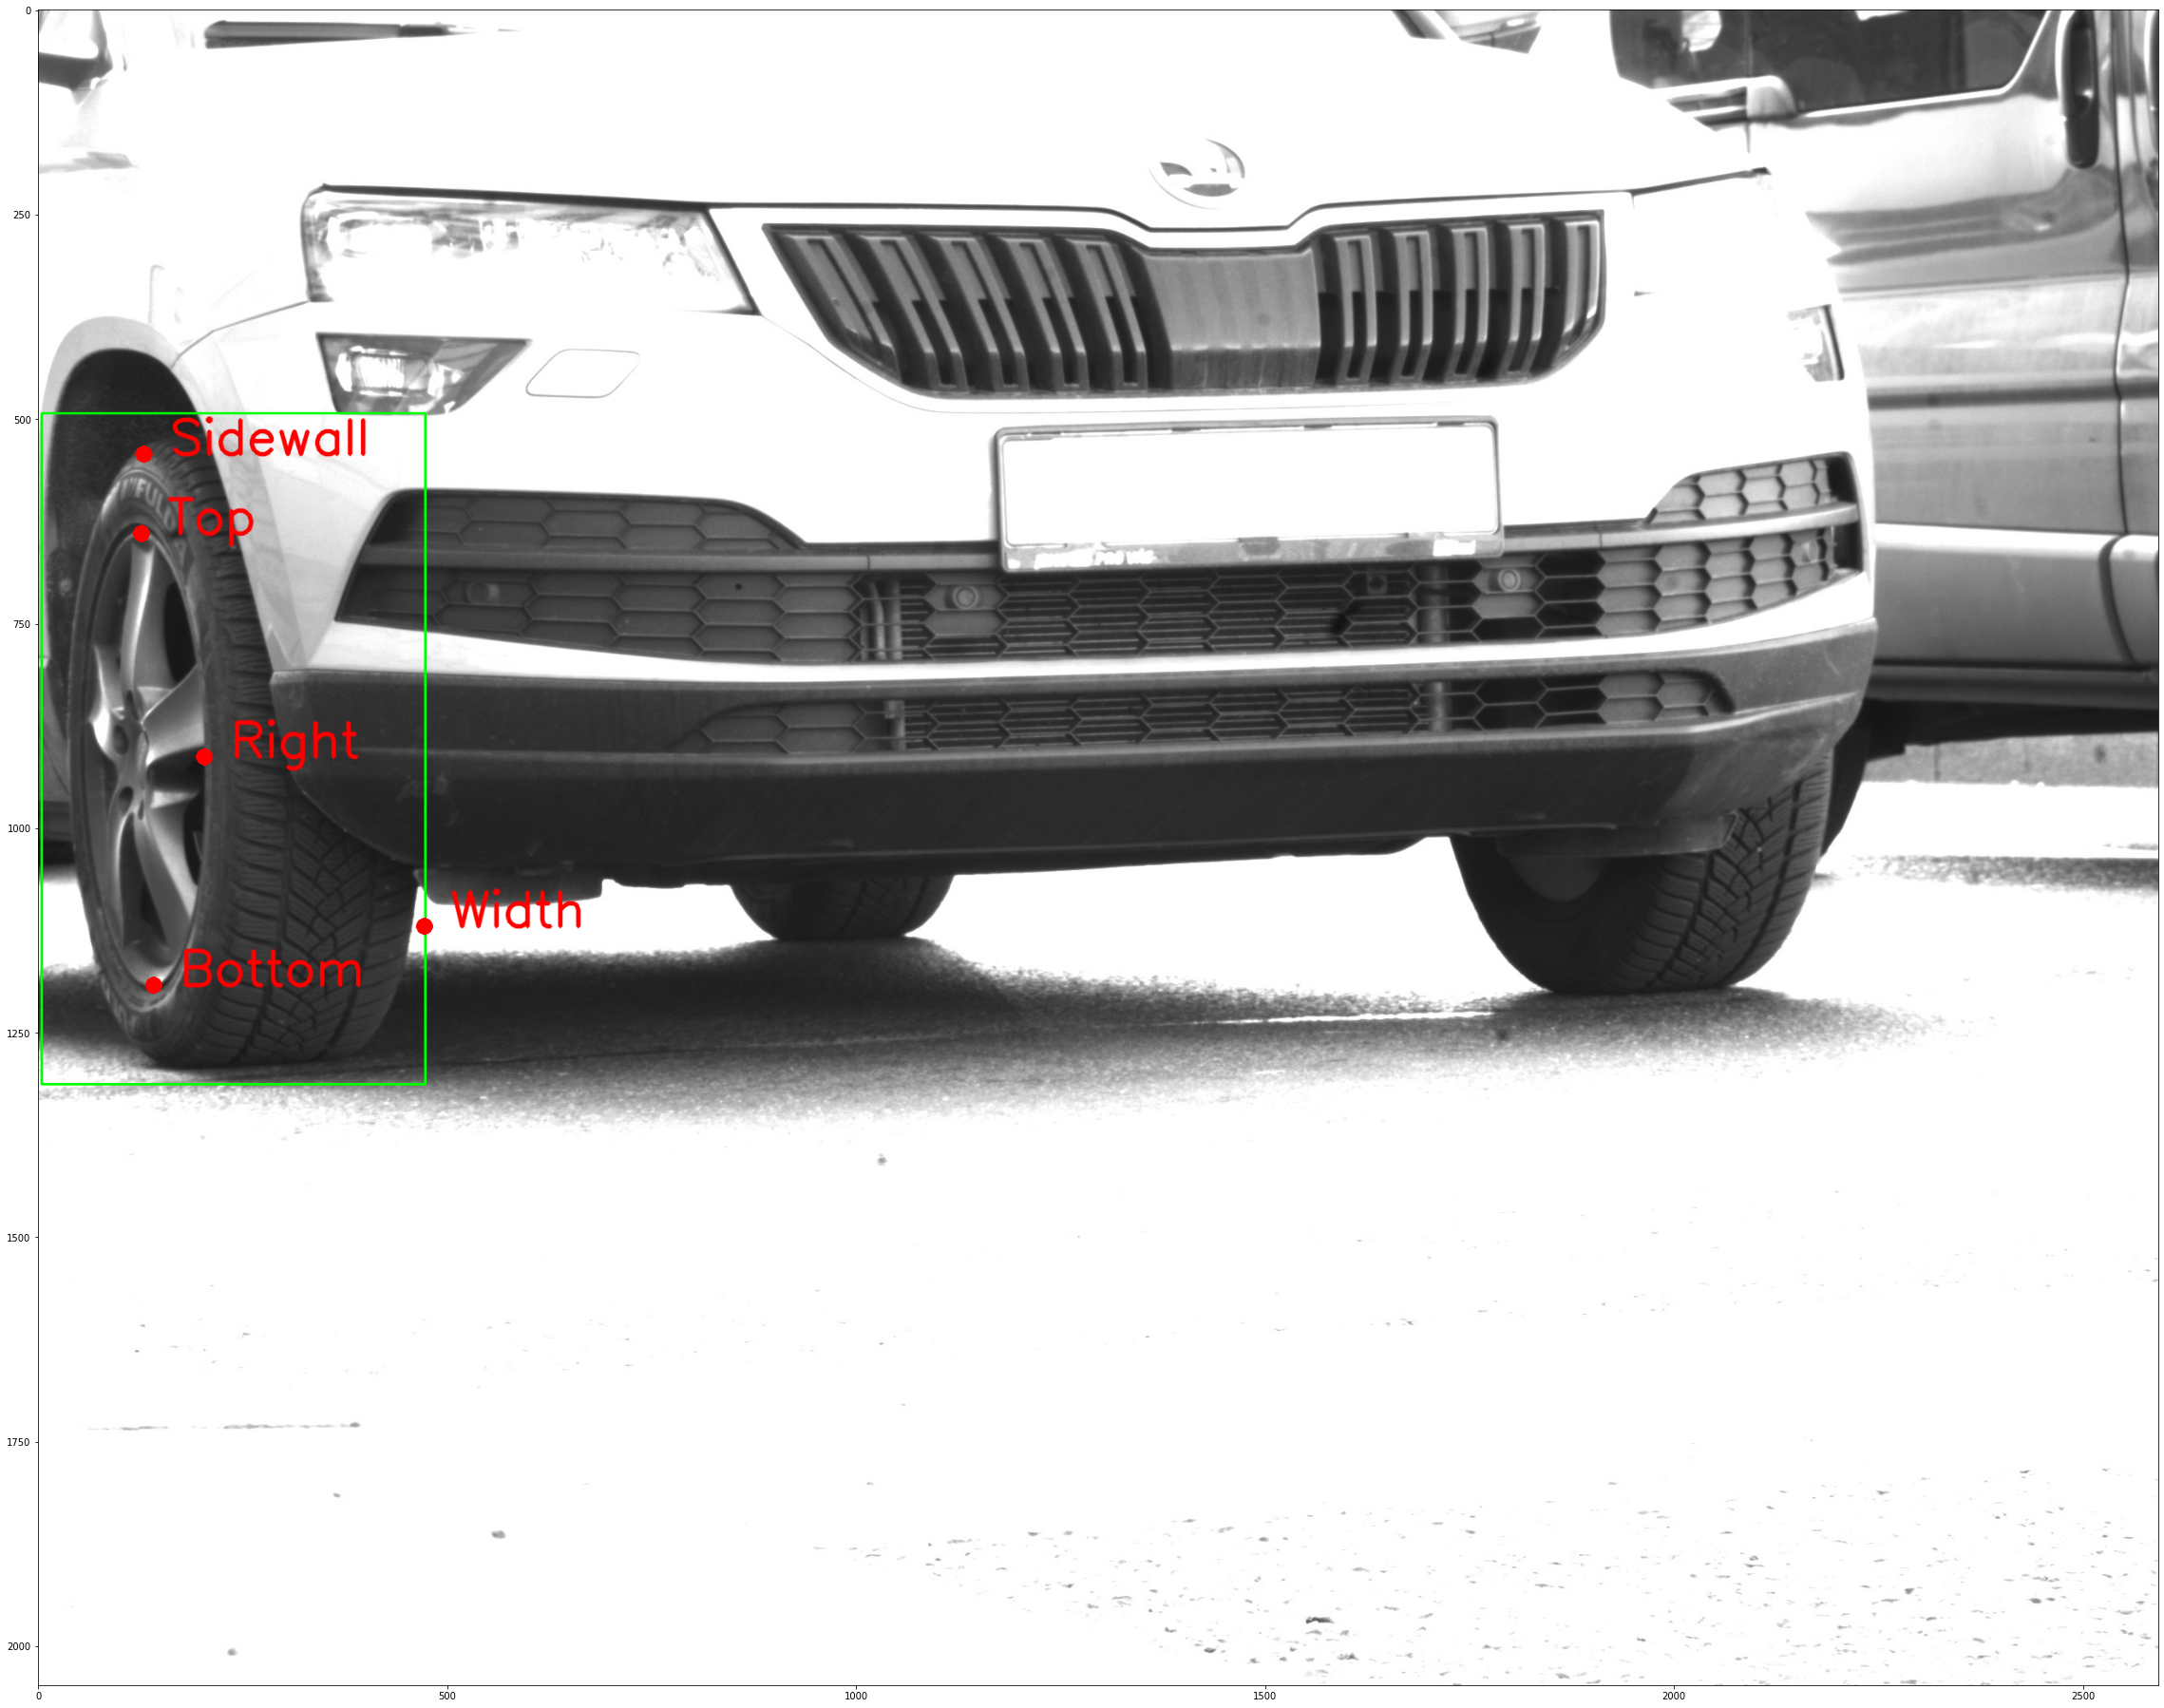

In [21]:
predict(test_images[0])